# Functions for Preprocessing Data

Load Modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import probplot
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing
import math

Lets get some data

In [5]:
from sklearn import datasets

In [6]:
iris = datasets.load_iris()

In [7]:
data = pd.DataFrame(iris['data'],columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])

In [8]:
print(data.head())

   Sepal Length  Sepal Width  Petal Length  Petal Width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


Function(s)

In [9]:
def processData(test_data, plots):
    
    #Find and Fix Holes
    def findFix(dat):
        data = dat.copy()
        print(' '),print('Holes at Start...'),print(' '),print(data.isna().sum())
        holes = pd.DataFrame(index=['Before','Nan','After','Mean for column','Mean of B and A','IndexOfHole','Column'])
        count = 0
        for i in list(data.columns):
            for j in list(data.loc[pd.isna(data[i]), :].index):
                holes[count] = [data[i].iloc[j-1],data[i].iloc[j],data[i].iloc[j+1],data[i].mean(),(data[i].iloc[j-1]+data[i].iloc[j+1])/2,j,i]
                count = count + 1
                data[i].iloc[j] = (data[i].iloc[j-1]+data[i].iloc[j+1])/2
        print(' '),print('Holes at End...'),print(' '),print(data.isna().sum())   
        return data

    #The holes have been removed and filled using the mean on the item before and after the hole.
    ndata = findFix(test_data)
    
    #Histograms
    def histPlot(a,c):    
        if c == 0:
            x = math.ceil(len(list(a.columns))/2)
            if x < 5:
                xx = 5
            fig, axs = plt.subplots(2,x,figsize=(8,8)) #sharex=True, sharey=True <- can be added to regularize the graphs
            count = 0
            countn = 0
            for i in a:
                if count < x:
                    axs[0,count].hist(list(a[i]), bins = int(len(a)**.5), stacked=True,color='tab:orange')#colors and labels
                    axs[0,count].set_title(i,size=20)
                    axs[0,count].legend(i,fontsize=20)
                    axs[0,count].grid(True)
                    count = count + 1
                else:
                    axs[1,countn].hist(list(a[i]), bins = int(len(a)**.5), stacked=True,color='tab:orange')#colors and labels
                    axs[1,countn].set_title(i,size=20)
                    axs[1,countn].legend(i,fontsize=20)
                    axs[1,countn].grid(True)
                    countn = countn + 1   
            plt.tight_layout()
            plt.show()
            
        elif c == 1:
            b = [list(a[i]) for i in a]
            plt.hist(b, bins = int(len(a)**.5), stacked=True)#colors and labels
            plt.legend(list(a.columns),fontsize=32)
            plt.title(list(a.columns),size=32)
            plt.grid(True)
            plt.show()
            
        return
    
    if plots == 1:
        histPlot(ndata,0)

    #QQ plot
    def qqPlot(a):
        def qq(x, axes = None):
            if axes is None:
                fig = plt.figure()
                ax1 = fig.add_subplot(1, 1, 1)
            else:
                ax1 = axes
            p = probplot(x, plot = ax1)
            ax1.set_title(x.name,fontsize=20)
            return p
        count = 1
        fig = plt.figure(figsize=(8,8))
        x = math.ceil(len(list(a.columns))/2)
        for i in a.columns:
            ax1 = fig.add_subplot(2,x, count)
            p1 = qq(a[i],ax1)
            count = count + 1
        fig.tight_layout()
        fig.show()
        return
    
    if plots == 1:
        qqPlot(ndata) 
 
    result = pd.DataFrame(index=['Mean','Count','Std','Kurtosis','Skew','Shapiro','NormalTest'])
    for i in list(ndata.columns):
        f = [ndata[i].mean(), ndata[i].describe()['count'],ndata[i].describe()['std'],kurtosis(ndata[i]),skew(ndata[i]),shapiro(ndata[i])[1],normaltest(ndata[i])[1]]    
        result[i] = [round(num,3) for num in f]

    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    nndata = pd.DataFrame()
    for i in list(ndata.columns):
        nndata[i] = sum(min_max_scaler.fit_transform(np.array(ndata[i]).reshape(-1,1)).tolist(),[])

    resultn = pd.DataFrame(index=['Mean','Count','Std','Kurtosis','Skew','Shapiro','NormalTest'])
    for i in list(nndata.columns):
        f = [nndata[i].mean(), nndata[i].describe()['count'],nndata[i].describe()['std'],kurtosis(nndata[i]),skew(nndata[i]),shapiro(nndata[i])[1],normaltest(nndata[i])[1]]    
        resultn[i] = [round(num,3) for num in f]
    
    print(' '),print(result),print(''),print(resultn),print(' ')
    
    def calculate_vif_(X, thresh):
        variables = list(range(X.shape[1]))
        dropped = True
        while dropped:
            dropped = False
            vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
            for ix in range(X.iloc[:, variables].shape[1])]

            maxloc = vif.index(max(vif))
            if max(vif) > thresh:
                print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                      '\' at index: ' + str(maxloc))
                del variables[maxloc]
                dropped = True

        print(' '),print('Recommended Remaining variables:')
        print(list(X.columns[variables]))
        return X.iloc[:, variables] 
    vif = calculate_vif_(nndata, thresh=10.0) #Threshold value should be adjusted per preference.
    
    return nndata, vif

 
Holes at Start...
 
Sepal Length    0
Sepal Width     0
Petal Length    0
Petal Width     0
dtype: int64
 
Holes at End...
 
Sepal Length    0
Sepal Width     0
Petal Length    0
Petal Width     0
dtype: int64


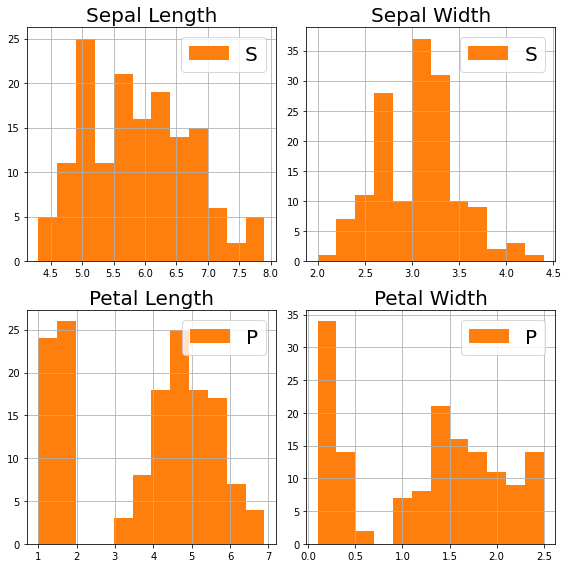

 
            Sepal Length  Sepal Width  Petal Length  Petal Width
Mean               5.843        3.057         3.758        1.199
Count            150.000      150.000       150.000      150.000
Std                0.828        0.436         1.765        0.762
Kurtosis          -0.574        0.181        -1.396       -1.336
Skew               0.312        0.316        -0.272       -0.102
Shapiro            0.010        0.101         0.000        0.000
NormalTest         0.057        0.210         0.000        0.000

            Sepal Length  Sepal Width  Petal Length  Petal Width
Mean               0.429        0.441         0.467        0.458
Count            150.000      150.000       150.000      150.000
Std                0.230        0.182         0.299        0.318
Kurtosis          -0.574        0.181        -1.396       -1.336
Skew               0.312        0.316        -0.272       -0.102
Shapiro            0.010        0.101         0.000        0.000
NormalTest         0.0

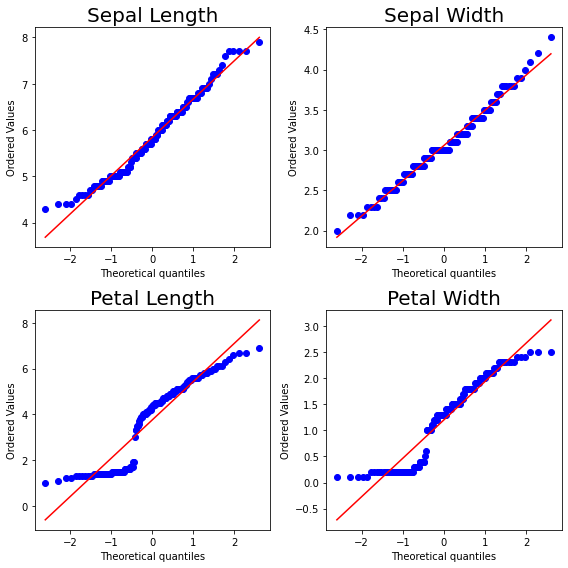

In [10]:
pre = processData(data,1)

The function return the processed data and the output from the multicollinearity analysis.

In [14]:
print(pre[0].head())

   Sepal Length  Sepal Width  Petal Length  Petal Width
0      0.222222     0.625000      0.067797     0.041667
1      0.166667     0.416667      0.067797     0.041667
2      0.111111     0.500000      0.050847     0.041667
3      0.083333     0.458333      0.084746     0.041667
4      0.194444     0.666667      0.067797     0.041667


In [15]:
print(pre[1].head())

   Sepal Width  Petal Width
0     0.625000     0.041667
1     0.416667     0.041667
2     0.500000     0.041667
3     0.458333     0.041667
4     0.666667     0.041667
